In [1]:
import scipy.io
import pandas as pd
import os
import numpy as np
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statistics import mode
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import LeaveOneGroupOut
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import accuracy_score

### Import files

In [2]:
folder_path = os.getcwd() + '\\dataset\\'
files = os.listdir(folder_path)

#Get all files related to all sensor positions
sensor_files = [file for file in files if file.endswith('.mat') and 'truth' not in file]
truth_files = [file for file in files if file.endswith('truth.mat')]  

In [3]:
data_frames = []
df_names = ['df1','df2','df3','df4','df5','df6','df7','df8','df9','df10']

for candidate in range(1, 11):  # 10 candidates
    candidate_files = [file for file in sensor_files if f'subject_{candidate}_' in file]
    truth_file = [file for file in truth_files if f'subject_{candidate}_ground' in file][0]

    candidate_data = []
    for file_name in candidate_files:
        data = scipy.io.loadmat(folder_path + file_name)
        x = data['x'].ravel()
        x, y, z = np.array_split(x, 3)
        candidate_data.append((x, y, z))

    t = data['t'].ravel()  # t is the same for all sensor positions

    truth_data = scipy.io.loadmat(folder_path + truth_file)
    label = truth_data['label'].ravel()
    label = [x[0] for x in label]

    df_name = f'df{candidate}'
    df = pd.DataFrame({'t': t})
    for i, sensor_position in enumerate(candidate_data):
        for j, axis in enumerate(['x', 'y', 'z']):
            df[f'{axis}_{i+1}'] = sensor_position[j]
    df['activity'] = label

    data_frames.append(df)
    globals()[df_name] = df

for df_name in df_names:
    df = globals()[df_name]
    df['activity'] = df['activity'].replace('upsatirs', 'upstairs')
    globals()[df_name] = df

### Preprocessing

#### Convert 3D accelerometer signal to 1D

In [4]:
for df_name in df_names:
    df = globals()[df_name]
    
    for i in range(1, 6):  # Iterate for each sensor position
        # Calculate the magnitude of the acceleration for each sensor position
        acc_mag = np.sqrt(df[f'x_{i}']**2 + df[f'y_{i}']**2 + df[f'z_{i}']**2)
        df[f'acc_mag{i}'] = acc_mag
    
    globals()[df_name] = df

In [5]:
# Delete x,y,z columns
for df_name in df_names:
    df = globals()[df_name]
    
    # Keep only the 'acc_mag', 'activity', and 't' columns
    df = df[['t', 'activity', 'acc_mag1', 'acc_mag2', 'acc_mag3', 'acc_mag4', 'acc_mag5']]
    
    globals()[df_name] = df

#### Replace sensor errors with previous value

In [6]:
for df_name in df_names:
    df = globals()[df_name]
    for i in range(1, 6):
        error_values = df[f'acc_mag{i}'] > 1000
        df.loc[error_values, f'acc_mag{i}'] = df[f'acc_mag{i}'].shift(1)[error_values]

#### Apply high-pass Butterworth filter

In [7]:
samp_freq = 100
cut_freq = 1
nyq_freq = 0.5 * samp_freq

# Normalize the cutoff frequency
cutoff = cut_freq / nyq_freq
# Butterworth filter with order=4
b, a = butter(4, cutoff, btype='highpass')

# Apply filter to each dataframe
for df_name in df_names:
    df = globals()[df_name].copy()  # Create a copy of the dataframe, otherwise we receive warnings
    for i in range(1, 6):
        acc_mag = df[f'acc_mag{i}']
        acc_mag_filt = filtfilt(b, a, acc_mag)
        df[f'acc_mag{i}_filt'] = acc_mag_filt
    
    globals()[df_name] = df  # Update the dataframe

### Feature extraction

In [8]:
window_len = 100    # 1 second with a sampling frequency of 100 Hz
windows_step = 100  # 1 second with a step of 1 second
num_frequency_bands = 10
band_limits = [nyq_freq / 2 ** (num_frequency_bands - i) for i in range(num_frequency_bands)]

data_frames_processed = []
dfs_processed = {}

for i, df_name in enumerate(df_names):
    df = globals()[df_name]
    features = []
    labels = []

    for j in range(0, len(df)-window_len+1, windows_step):
        window_features = []
        window_labels = []

        for k in range(1, 6):
            acc_mag_filt = df[f'acc_mag{k}_filt'][j:j+window_len]
            freq, power_spectrum = welch(acc_mag_filt, fs=100, nperseg=window_len, noverlap=0)

            power_in_bands = [] # power in each frequency band
            for l in range(len(band_limits)):
                freqs_in_band = np.where((freq >= band_limits[l]) & (freq < band_limits[l+1]))[0] if l < len(band_limits)-1 else np.where(freq >= band_limits[l])[0]
                power_in_bands.append(np.sum(power_spectrum[freqs_in_band]))

            window_features.extend(power_in_bands)

            window_labels.extend(df['activity'][j:j+window_len].values)

        features.append(window_features)

        label = mode(window_labels)
        labels.append(label)

    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Create new dataframe with windowed features and labels
    df_processed = pd.DataFrame(normalized_features, columns=['f' + str(k) for k in range(len(normalized_features[0]))])
    df_processed['activity'] = labels

    # Append dataframe to list
    data_frames_processed.append(df_processed)
    dfs_processed[f'df_p{i+1}'] = df_processed


# Create new dataframe variables
for i, key in enumerate(dfs_processed.keys()):
    name = f"df_p{i+1}"
    globals()[name] = dfs_processed[key]


### LOSO training using SVM classifier

In [9]:
logo = LeaveOneGroupOut()

X = pd.concat([df.iloc[:, :-1] for df in data_frames_processed])
y = pd.concat([df['activity'] for df in data_frames_processed])
groups = ['p1']*len(df_p1) + ['p2']*len(df_p2) + ['p3']*len(df_p3) + ['p4']*len(df_p4) + ['p5']*len(df_p5) + ['p6']*len(df_p6) + ['p7']*len(df_p7) + ['p8']*len(df_p8) + ['p9']*len(df_p9) + ['p10']*len(df_p10)

In [24]:
confusion_matrices = []
accuracies = []
for train_index, test_index in logo.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    p = X_train.shape[1]
    gamma = 1/p
    
    clf = SVC(kernel='rbf', C=1, gamma=gamma)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, normalize='true')*100
    confusion_matrices.append(cm)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
final_cm = sum(confusion_matrices)
summarized_accuracy = np.mean(accuracies)
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

      biking       0.80      0.65      0.72       900
  downstairs       0.83      0.77      0.80       900
     jogging       0.80      0.74      0.77       900
     sitting       0.67      0.85      0.75       900
    standing       1.00      0.99      0.99       900
    upstairs       0.94      0.97      0.96       900
     walking       0.79      0.83      0.81       900

    accuracy                           0.83      6300
   macro avg       0.83      0.83      0.83      6300
weighted avg       0.83      0.83      0.83      6300



In [21]:
print(f"Accuracy: {summarized_accuracy:.2%}")

Accuracy: 76.90%


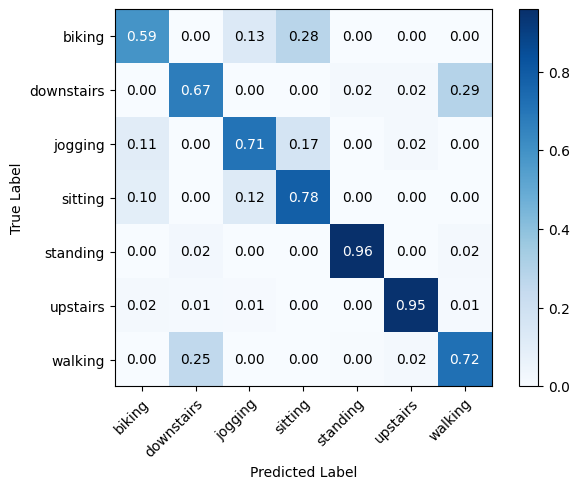

In [22]:
classes = np.unique(y)
norm_cm = final_cm / final_cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots()
im = ax.imshow(norm_cm, cmap='Blues')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, format(norm_cm[i, j], '.2f'),
                       ha="center", va="center", color="white" if norm_cm[i, j] > 0.5 else "black");
cbar = ax.figure.colorbar(im, ax=ax)
fig.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix_all_positions.png', bbox_inches='tight')